In [1]:
import torch
import os
import numpy as np
from models import SAVi
from data import gestalt
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from metrics import adjusted_rand_index 

%load_ext autoreload
%autoreload 2

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dl = DataLoader(gestalt.Gestalt(root_dir="/om2/user/yyf/CommonFate/scenes", sub_level=["superquadric_2", "superquadric_3"]),
               batch_size=4)

64 6


In [3]:
batch = next(iter(dl))

images = batch['images']
flows = batch['flows']
masks = batch['masks']

In [4]:
masks.shape

torch.Size([1, 5, 10, 3, 128, 128])

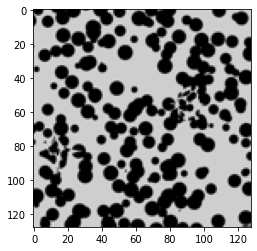

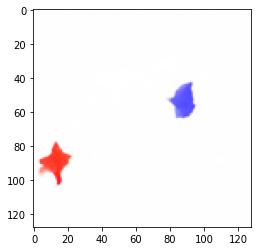

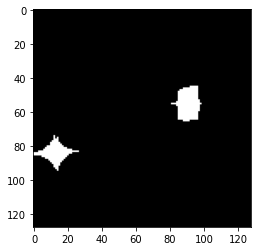

In [5]:
plt.imshow(images[0][0].cpu().numpy().transpose(2, 1, 0))
plt.show()
plt.imshow(flows[0][0].cpu().numpy().transpose(2, 1, 0))
plt.show()
plt.imshow(masks.sum(dim=1)[0, 0].cpu().numpy().transpose(2, 1, 0), cmap="gray")
plt.show()

In [10]:
from torch.nn import functional as F
import metrics 

model = SAVi.SlotAttentionVideo(num_slots=5).float().to(device)
torch.autograd.set_detect_anomaly(True)
optim = torch.optim.Adam(model.parameters(), lr=0.0002)

losses = []
for i in range(1000):
    optim.zero_grad()
    out = model(images, cues=masks[:, :, 0])
    recons_combined = out['recon_combined']

    loss = F.mse_loss(recons_combined, flows)
    pred_masks = out["masks"].detach()
    gt_masks = (
        batch["masks"].detach().sum(dim=3, keepdim=True)
    )  # Combine RGB channels into one
    B, N, T, C, H, W = gt_masks.shape
    gt_masks = gt_masks.reshape((B, N, T, H, W, C))
    pred_masks = pred_masks.transpose(1, 2)

    pred_groups = pred_masks.reshape(1, N, -1).permute(
        0, 2, 1
    )
    true_groups = gt_masks.reshape(1, N, -1).permute(0, 2, 1)
    fg_ari = metrics.adjusted_rand_index(true_groups, pred_groups)

    gt_masks = gt_masks[:, 1:, ...].sum(
        dim=1
    )  # Combine individual mask slots and ignore backgrounds
    pred_masks = pred_masks.sum(dim=1)
    mean_IOU = metrics.mean_IOU(gt_masks, pred_masks)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.05)
    loss.backward()
    if i % 10 == 0:
        print("MSE: ", loss.item(), "IOU: ", mean_IOU.item(), "fg_ari: ", fg_ari.item())
    
    losses.append(loss.item())
    optim.step()
    

MSE:  1.1273155212402344 IOU:  0.21166382730007172 fg_ari:  0.00013782893074676394
MSE:  0.49695566296577454 IOU:  0.21425171196460724 fg_ari:  -0.0006221327930688858
MSE:  0.27127230167388916 IOU:  0.2132670134305954 fg_ari:  -0.0028274445794522762
MSE:  0.15398834645748138 IOU:  0.21158650517463684 fg_ari:  -0.017301861196756363
MSE:  0.096176877617836 IOU:  0.21336467564105988 fg_ari:  0.0013831059914082289
MSE:  0.07129929959774017 IOU:  0.2137349396944046 fg_ari:  0.003251986810937524
MSE:  0.05625057592988014 IOU:  0.21270751953125 fg_ari:  -3.7323225114960223e-05
MSE:  0.04667932167649269 IOU:  0.21228638291358948 fg_ari:  -0.002136619994416833
MSE:  0.039220500737428665 IOU:  0.21206460893154144 fg_ari:  -0.0027571390382945538
MSE:  0.032231882214546204 IOU:  0.21222738921642303 fg_ari:  -0.00179626967292279
MSE:  0.02597574144601822 IOU:  0.21265259385108948 fg_ari:  -0.002024618210271001
MSE:  0.020750204101204872 IOU:  0.21238403022289276 fg_ari:  -0.0018996510189026594
MSE:

KeyboardInterrupt: 

In [7]:
out.keys()

dict_keys(['recon_combined', 'recons', 'masks', 'slots'])

In [11]:
out['recon_combined'].shape

torch.Size([1, 10, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


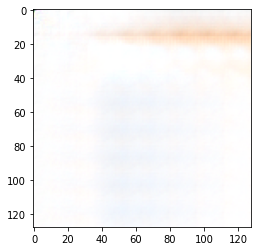

In [12]:
plt.imshow(out["recon_combined"][0,0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [76]:
recons = (recons_combined - recons_combined.min()) / recons_combined.max()

In [77]:
masks = out['masks']
masks_usable = masks.squeeze(0).detach().cpu().numpy().transpose(1, 0, 2, 3, 4)

In [79]:
masks_usable.shape

(5, 10, 128, 128, 1)

In [81]:
out['recons'].shape

torch.Size([1, 10, 5, 128, 128, 3])

In [82]:
list_masks = list(masks_usable)

In [83]:
titles = [f"mask_{i}" for i in range(3)]

In [84]:
import sys
sys.path.append("../")
from utils import make_video


(<Figure size 864x576 with 5 Axes>,
 <matplotlib.animation.FuncAnimation at 0x2ac05f9549a0>)

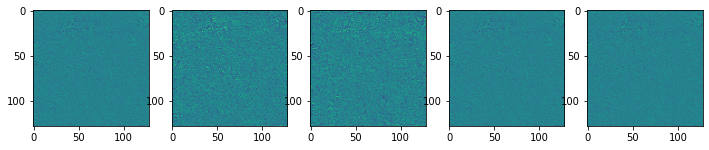

In [85]:
make_video(list_masks, titles=titles, output_name="masks")

In [86]:
recons.shape

torch.Size([1, 10, 3, 128, 128])

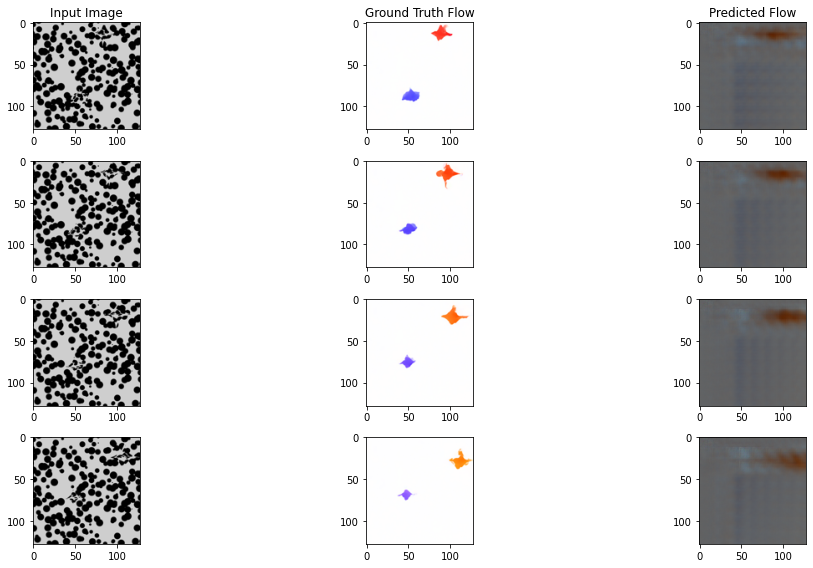

In [87]:
fig, axs = plt.subplots(4, 3, figsize=(16, 8))

for i in range(4):
    img= axs[i, 0].imshow(images[0][i*2].detach().cpu().numpy().transpose(1, 2, 0))
    axs[i, 1].imshow(flows[0][i* 2].detach().cpu().numpy().transpose(1, 2, 0))
    axs[i, 2].imshow(recons[0][i*2].detach().cpu().numpy().transpose(1, 2, 0))

axs[0, 0].set_title("Input Image")
axs[0, 1].set_title("Ground Truth Flow")
axs[0, 2].set_title("Predicted Flow")

plt.tight_layout()
plt.show()

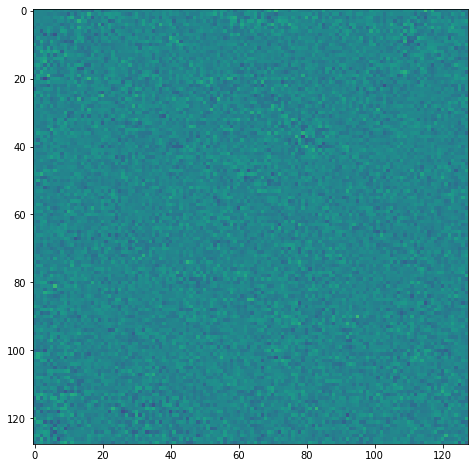

In [88]:
vid = make_video(masks_usable[1], 
                output_dir="figures", output_name="slots_0", format="mp4")

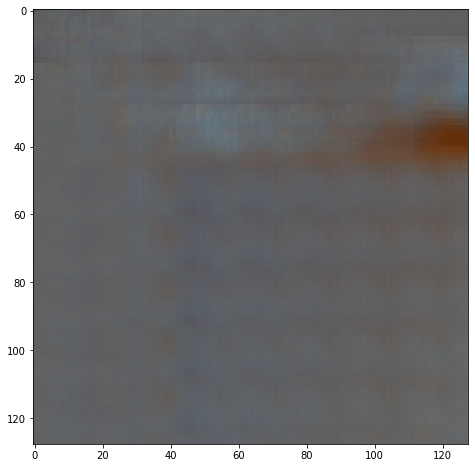

In [89]:
import sys
sys.path.append("../")
from utils import make_video
from matplotlib import animation
from IPython.display import HTML
from matplotlib import animation, rc

fig1, ani1 = make_video(recons.squeeze().detach().cpu().numpy().transpose(0, 2, 3, 1), 
                        output_dir="figures", output_name="overfit_0", format="mp4")
HTML(ani1.to_jshtml())
plt.show()


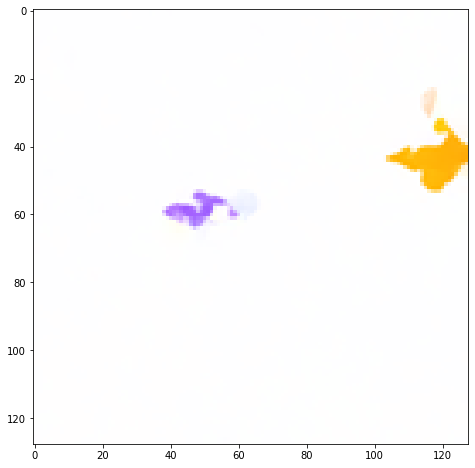

In [90]:
fig2, ani2 = make_video(flows.squeeze().detach().cpu().numpy().transpose(0, 2, 3, 1),
                       output_dir="figures", output_name="overfit_0_flows", format="mp4")
HTML(ani2.to_jshtml())
plt.show()


<IPython.core.display.Javascript object>


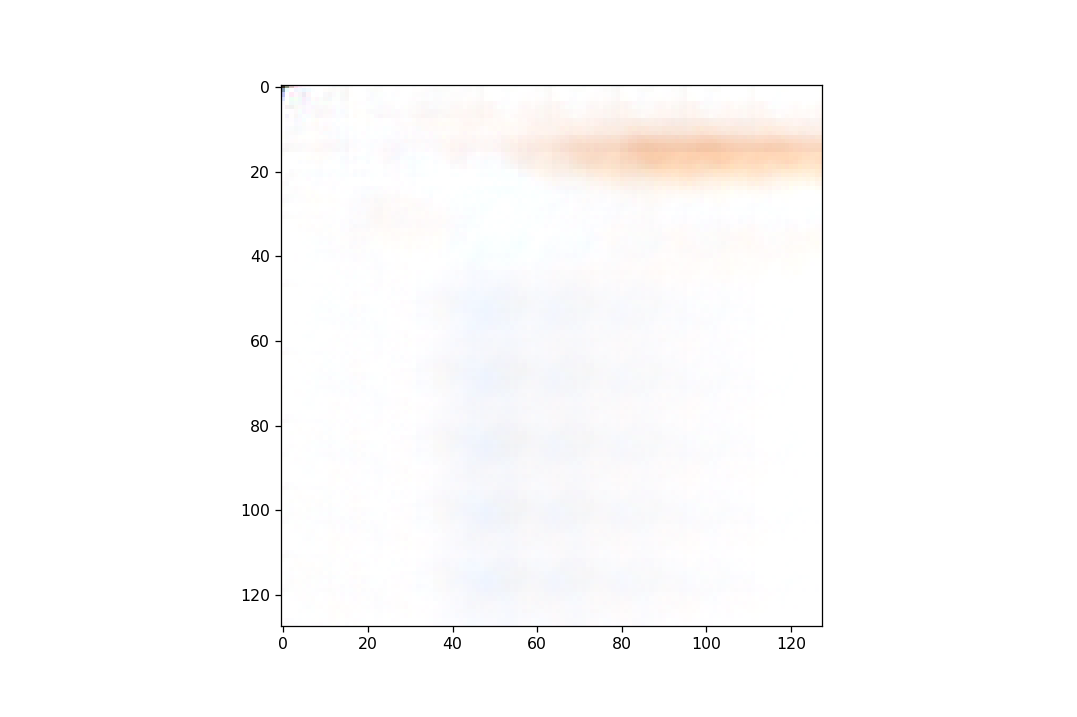

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [477]:
plt.imshow(recons_combined[0, 1].permute(1, 2, 0).detach().cpu().numpy())
plt.show()
